# **Preprocessing of the BDD100K Dataset**

The [BDD100K](https://github.com/bdd100k/bdd100k/) dataset is the largest open video dataset for autonomous driving, containing 100,000 videos and covering 10 computer vision tasks. It features geographic, environmental, and meteorological diversity, with dynamic outdoor scenes captured at different times of the day. Moreover, the complex motion of the autonomous vehicle makes perception tasks particularly challenging. For instance segmentation, detailed pixel-level annotations are provided for images from 10,000 randomly selected video clips from the dataset. This set is divided into three parts: 7,000 images for training, 1,000 for validation, and 2,000 for testing (not publicly available), using the same 8 classes as defined in the instance segmentation of the [Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/) dataset.

## **Imports**

In [ ]:
# Necessary libraries to determine the dataset classes
!pip install appdirs -q
!pip install cityscapesscripts -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 585.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import cityscapesscripts.helpers.labels as cs_labels
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
from tqdm.auto import tqdm
from google.colab import drive
import shutil
import json
import yaml
import os

In [3]:
# Mount Google Drive in Colab
drive.mount("/content/drive")

Mounted at /content/drive


## **Parameters**

In [4]:
train_images_url = "https://dl.cv.ethz.ch/bdd100k/data/10k_images_train.zip"
val_images_url = "https://dl.cv.ethz.ch/bdd100k/data/10k_images_val.zip"
labels_url = "https://dl.cv.ethz.ch/bdd100k/data/bdd100k_ins_seg_labels_trainval.zip"
dataset_dir = "/content/BDD100K"
zip_dataset_path = "/content/drive/MyDrive/Datasets/BDD100K.zip"

os.makedirs(dataset_dir, exist_ok=True)

## **Download and Extract Dataset**

All datasets for all BDD100K tasks are available at the following [official link](https://dl.cv.ethz.ch/bdd100k/data/).

In [ ]:
raw_train_images_dir = tf.keras.utils.get_file(
    origin=train_images_url,
    cache_dir=os.getcwd(),
    extract=True
)

raw_val_images_dir = tf.keras.utils.get_file(
    origin=val_images_url,
    cache_dir=os.getcwd(),
    extract=True
)

raw_labels_dir = tf.keras.utils.get_file(
    origin=labels_url,
    cache_dir=os.getcwd(),
    extract=True
)

raw_train_images_dir = os.path.join(raw_train_images_dir, "bdd100k/images/10k/train")
raw_val_images_dir = os.path.join(raw_val_images_dir, "bdd100k/images/10k/val")
raw_labels_dir = os.path.join(raw_labels_dir, "bdd100k/labels/ins_seg/polygons")

781903245/781903245 ━━━━━━━━━━━━━━━━━━━━ 39s 0us/step
150137879/150137879 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
111232086/111232086 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Extract the classes and their respective colors
class_names, class_colors = [], []

for label in cs_labels.labels:
  if label.hasInstances and not label.ignoreInEval:
    class_names.append(label.name)
    class_colors.append(label.color)

sorted_classes = sorted(zip(class_names, class_colors))
class_names, class_colors = map(list, zip(*sorted_classes))

print(len(class_names))
print(class_names)
print(class_colors)

8
['bicycle', 'bus', 'car', 'motorcycle', 'person', 'rider', 'train', 'truck']
[(119, 11, 32), (0, 60, 100), (0, 0, 142), (0, 0, 230), (220, 20, 60), (255, 0, 0), (0, 80, 100), (0, 0, 70)]


In both the Cityscapes and BDD100K datasets, for instance segmentation, the classes `caravan` and `trailer` are excluded from the evaluation. Without ignoring any classes, the class list would be as follows:  
`['bicycle', 'bus', 'car', 'caravan', 'motorcycle', 'person', 'rider', 'trailer', 'train', 'truck']`

## **Preprocess the Dataset**

In [ ]:
# Extract the training and validation annotations
with open(os.path.join(raw_labels_dir, "ins_seg_train.json"), "r") as file:
  train_annotations = json.load(file)

with open(os.path.join(raw_labels_dir, "ins_seg_val.json"), "r") as file:
  val_annotations = json.load(file)

print(len(train_annotations), len(val_annotations))
print(train_annotations[0].keys())

7000 1000
dict_keys(['name', 'labels'])


In instance segmentation, verifying whether duplicate contours exist for a given instance is more complex compared to object detection. This is because some contours may differ slightly in one or more coordinates. As a result, simply adding them to a Python set would not detect them as duplicates.  

To address this issue, duplicates are identified by comparing the bounding box coordinates of each contour rather than the individual contour coordinates.

In [ ]:
# Function to remove duplicate labels
def remove_duplicates(labels):
  bboxes = set()
  unique_labels = []

  for label in labels:
    polygon = np.array(label[1:], dtype=np.float32).reshape(-1, 2)
    xmin, ymin = polygon.min(axis=0)
    xmax, ymax = polygon.max(axis=0)
    bbox = (xmin, ymin, xmax, ymax)

    if bbox not in bboxes:
      bboxes.add(bbox)
      unique_labels.append(label)

  return unique_labels

For instance segmentation with [YOLO by Ultralytics](https://docs.ultralytics.com/datasets/segment/#ultralytics-yolo-format), each row in the label file corresponding to an image must follow this format:  

**`class_index, x1, y1, ..., xn, yn`**  

Where:  
- Each row represents an object instance.  
- The contour (polygon) coordinates are normalized within the range $[0, 1]$.  
- Each instance must have at least **three (X, Y) coordinate pairs**.  
- Each convex object must be represented by **a single contour**. 

All images in the BDD100K dataset have dimensions of `(720, 1280)`, and the instance mask annotations are provided as contour coordinates, with each instance having a single contour. Therefore, only coordinate normalization is required.

In [ ]:
# Function to preprocess and save images and masks
def save_data(annotations, split="train"):

  # Create the image and label directories
  images_dir = os.path.join(dataset_dir, split, "images")
  labels_dir = os.path.join(dataset_dir, split, "labels")

  os.makedirs(images_dir, exist_ok=True)
  os.makedirs(labels_dir, exist_ok=True)

  for annotation in tqdm(annotations):
    # Extract the filename and determine the image path
    filename = annotation["name"].replace(".jpg", "")
    image_path = os.path.join(
        raw_train_images_dir if split == "train" else raw_val_images_dir,
        f"{filename}.jpg"
    )
    
    # Extract the image dimensions and raw annotations
    width, height = Image.open(image_path).size
    raw_labels = annotation["labels"]

    labels = []
    for label in raw_labels:
      name = label["category"]

      if name in class_names:
        # Extract the class and coordinates of the given instance
        cls = class_names.index(name)
        contour = label["poly2d"][0]["vertices"]

        if len(contour) < 3:
          print(f"Contour contains fewer than 3 (x, y) points in: {filename}")
          continue
        
        # Normalize the contour coordinates
        contour = np.array(contour, np.float32)
        contour[:, 0] /= width
        contour[:, 1] /= height
        contour = np.clip(contour, 0, 1)
        contour = contour.flatten().tolist()
        labels.append([cls] + contour)
    
    # Remove duplicate labels
    labels = remove_duplicates(labels)

    # Discard empty labels
    if not labels:
      print(f"No labels present in {filename}")
      continue

    # Save the images and labels
    with open(os.path.join(labels_dir, f"{filename}.txt"), "w") as file:
      file.writelines(" ".join(map(str, row)) + "\n" for row in labels)

    shutil.copy(image_path, os.path.join(images_dir, f"{filename}.jpg"))

In [11]:
save_data(train_annotations)
save_data(val_annotations, split="val")

  0%|          | 0/7000 [00:00<?, ?it/s]

No labels present in c53221aa-4ef98335
No labels present in 16330b51-c7342f6c
No labels present in 74634268-dbe4c302
No labels present in 7ab59a26-00000000
No labels present in 1ed883b8-80bb388d
No labels present in 357506e4-3a64f522
No labels present in 4d57d6d9-02d638bd
No labels present in 4d569119-99220cfa
No labels present in 1af21ce1-e157b867
No labels present in 04f64fe8-00000000
No labels present in 7c761a2a-7f53f8d7
No labels present in 560caf77-3b1ac1f7
No labels present in 3f9f7fc0-f2160541
No labels present in bb793416-9423221d
No labels present in 9d2c870a-a0b6ac72
No labels present in 1b798e43-2515a312
No labels present in 1b5713fe-2242775e
No labels present in b4f360ca-78e0a64c
No labels present in 648b2387-05000000
No labels present in 3d860ec4-d7102e99
No labels present in a279854d-162bd02c
No labels present in 72d1a01b-00000000
No labels present in 0512a400-d2fa24da
No labels present in 707dd947-66e02ad8
No labels present in 2b71e164-38b71151
No labels present in 3780

  0%|          | 0/1000 [00:00<?, ?it/s]

No labels present in 98315875-8fafca70
No labels present in a91b7555-00000400
No labels present in 8fc16e83-4768a0df
No labels present in 9be17795-514a62a1
No labels present in 84af3c94-a97338a7
No labels present in a12decc8-580615fb
No labels present in 84213c19-5bd945d3
No labels present in a549cc54-a8daa04b
No labels present in 802fc65c-d32f4149
No labels present in 88b0a96a-00000000
No labels present in 98315875-2c8d6266
No labels present in 8abb1e0e-8888c6b6
No labels present in 8884fc34-7efe5672
No labels present in 91ada70d-69cf70ac
No labels present in 9f7d0810-920ea2dc
No labels present in 9bcccfec-e004fb23
No labels present in 7e365190-9193658c
No labels present in 9f160587-fd77bcf9
No labels present in 872cc208-00000000
No labels present in a1b929da-adb10837


In [ ]:
# Number of images and labels after preprocessing
print(
    len(os.listdir(os.path.join(dataset_dir, "train/images"))),
    len(os.listdir(os.path.join(dataset_dir, "train/labels")))
)

print(
    len(os.listdir(os.path.join(dataset_dir, "val/images"))),
    len(os.listdir(os.path.join(dataset_dir, "val/labels")))
)

6887 6887
980 980


In [ ]:
# Create and save the YAML file with the dataset metadata
metadata = {
    "path": f"../{os.path.basename(dataset_dir)}",
    "train": "train/images",
    "val": "val/images",
    "names": {i: name for i, name in enumerate(class_names)},
    "colors": {i: list(color) for i, color in enumerate(class_colors)}
}

with open(os.path.join(dataset_dir, "data.yaml"), "w") as file:
  yaml.dump(metadata, file,default_flow_style=False, sort_keys=False)

In [15]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Exploratory Data Analysis (EDA)**

In [17]:
# Function to extract instance counts per class
def count_instances(data_dir):
  dic_classes = {name: 0 for name in class_names}
  label_paths = glob(os.path.join(data_dir, "*.txt"))

  for path in tqdm(label_paths):
    with open(path, "r") as file:
      classes = [int(row.split()[0]) for row in file.readlines()]

    for cls in classes:
      dic_classes[class_names[cls]] += 1

  df = pd.DataFrame(list(dic_classes.items()), columns=["Class", "Count"])
  return df

In [18]:
num_train_instances = count_instances(os.path.join(dataset_dir, "train/labels"))
num_val_instances = count_instances(os.path.join(dataset_dir, "val/labels"))

  0%|          | 0/6887 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

In [19]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.6 MB/s eta 0:00:00


In [20]:
# Function to plot a barplot of class counts
def plot_counts(num_instances, split="training", renderer=None):
  num_instances = num_instances.sort_values(by="Count")
  fig = px.bar(
      num_instances, x="Count", y="Class", title="Counts of Classes",
      text="Count", color="Count",
      color_continuous_scale=[(0, "#D80000"), (0.5, "lightblue"), (1, "#003299")]
  )

  total_count = num_instances.Count.sum()
  fig.update_layout(
      title=dict(
          text=f"Class Count in the {split.capitalize()} Set (Total: {total_count})",
          font=dict(size=15, weight="bold"),
          x=0.5
      ),
      xaxis_title=dict(text="Frequency", font=dict(size=12, weight="bold")),
      yaxis_title=dict(text="Class", font=dict(size=12, weight="bold")),
      height=500,
      width=1000
  )
  fig.show(renderer=renderer)

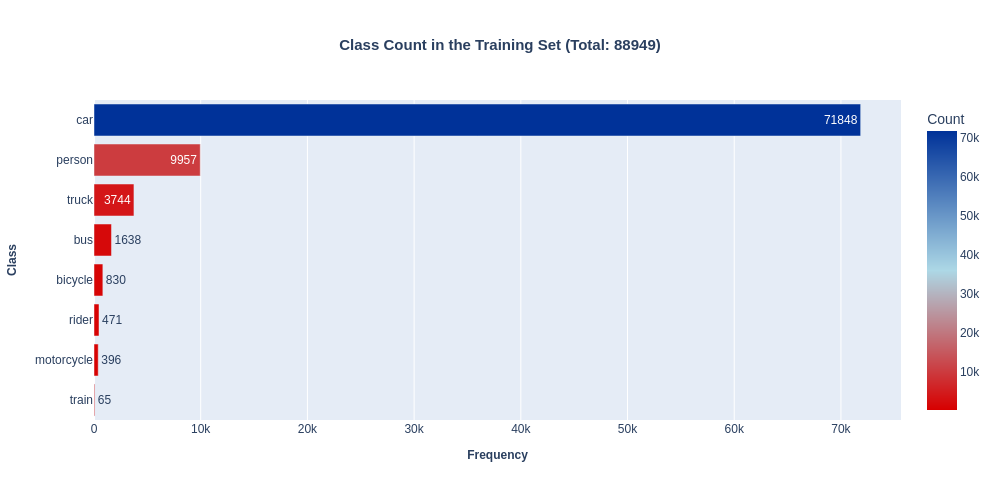

In [21]:
plot_counts(num_train_instances)
plot_counts(num_train_instances, renderer="png")

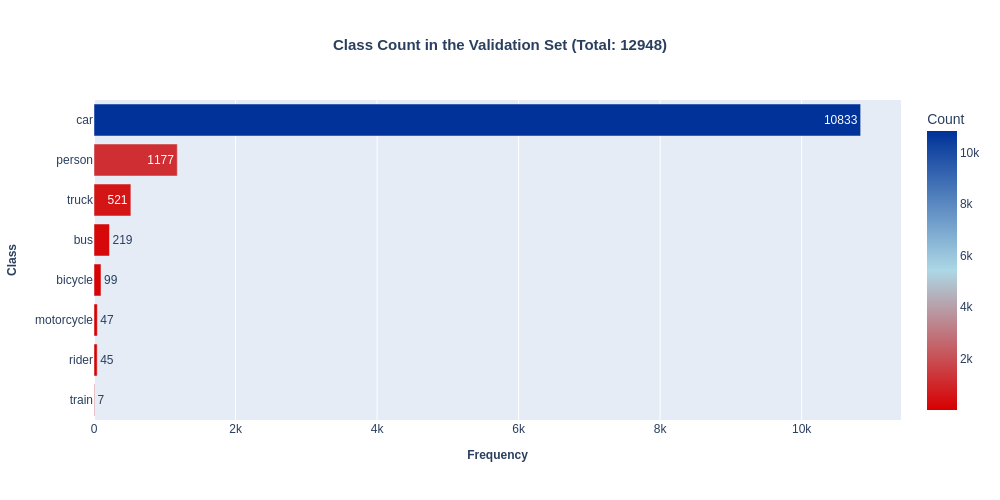

In [22]:
plot_counts(num_val_instances, split="validation")
plot_counts(num_val_instances, split="validation", renderer="png")

One disadvantage of the BDD100K dataset compared to Cityscapes is that it contains fewer instances of the `train` class, despite having a greater total number of instances. The number of instances for the `train` class is so low that, in both the validation and training sets, segmentation models generally do not detect any instance during evaluation. This is evident, for example, in the semantic segmentation results reported in the [official article](https://arxiv.org/pdf/1805.04687) of BDD100K, where an **IoU of 0** is achieved for the `train` class even in the training set, despite semantic segmentation being less complex than instance segmentation. Therefore, for the BDD100K dataset to be fully robust, it would be necessary to include images with a higher number of `train` instances, allowing for the refinement or training of more robust computer vision models for autonomous driving.

## **Visualization Example**

In [23]:
train_image_paths = sorted(glob(os.path.join(dataset_dir, "train/images/*.jpg")))

In [24]:
id = 0 #np.random.randint(len(train_image_paths))

image_path = train_image_paths[id]
image = np.array(Image.open(image_path))

with open(image_path.replace("images", "labels").replace(".jpg", ".txt"), "r") as file:
  labels = [row.split() for row in file.readlines()]

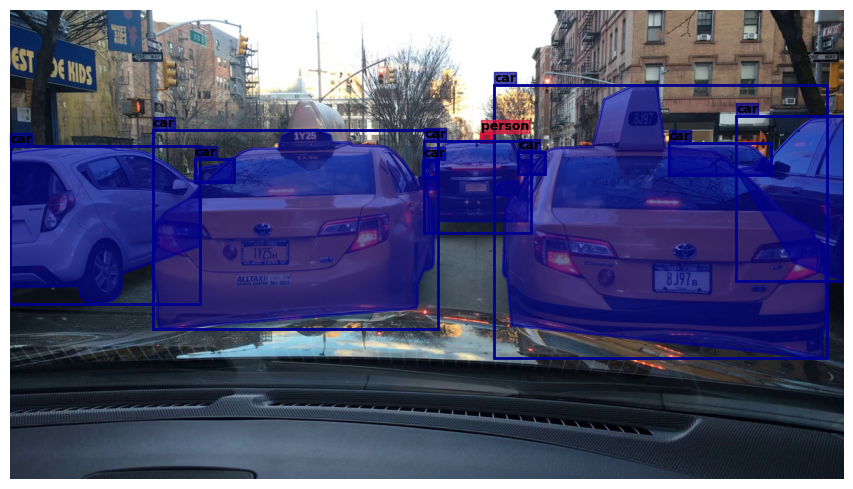

In [25]:
fig, ax = plt.subplots(1, figsize=(9, 9))
shape = image.shape

ax.imshow(image)
for label in labels:
  cls = int(label[0])
  color = class_colors[cls]
  color = tuple(np.array(color) / 255)

  contour = np.array(label[1:]).reshape(-1, 2).astype(np.float32)
  contour[:, 0] *= shape[1]
  contour[:, 1] *= shape[0]
  polygon = patches.Polygon(contour, facecolor=color, edgecolor=color, alpha=0.6, linewidth=2)

  xmin, ymin = contour.min(axis=0)
  xmax, ymax = contour.max(axis=0)
  rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor="none")

  ax.add_patch(polygon)
  ax.add_patch(rect)
  ax.text(
      x=xmin, y=ymin, s=f"{class_names[cls]}",
      color="black", fontsize=9, fontweight="bold", ha="left", va="bottom",
      bbox={"boxstyle": "square,pad=0", "facecolor": color, "edgecolor": color, "alpha": 0.7}
  )

plt.tight_layout()
ax.axis("off");